Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# The automated cell did not work when using colab with a local runtime
DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [0]:
import category_encoders as ce
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

### Existing work

(condensed into one code cell)

In [0]:
# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')

# Feature engineering: cluster the latitude and longitude coordinates
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=20)
train['cluster'] = kmeans.fit_predict(train[['longitude', 'latitude']])
test['cluster'] = kmeans.predict(test[['longitude', 'latitude']])

# feature engineering: number of other pumps within a certain distance
# setting a .1 default for distance because these are long distances
#   Length of 1° of latitude = always 111.32 km
#   Length of 1° of longitude = 40075 km * cos( latitude ) / 360
def count_neighbors(data, row, max_distance=.1):
  """ 
  returns the number of neighbors by checking distance using 
  lat/lon coordinates, closer than max_distance

  since I'm not calculating euclidian distance (which took far longer), 
  this is essentially a square with radius max_distance
  """
  squared_dist = max_distance**2
  this_point = [data.iloc[row]['longitude'], data.iloc[row]['latitude']]
  count = 0
  
  return len(data[((data['longitude']-this_point[0])**2 < squared_dist) &
                  ((data['latitude']-this_point[1])**2 < squared_dist)])

# Data wrangling I already had from the lectures and other assignments
def clean_engineer(X):
    """Clean and engineer the different sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
            
    # drop some duplicate, constant, or unique columns
    cols_to_drop = ['quantity_group', 'payment', 'recorded_by', 'id']
    X = X.drop(columns=cols_to_drop)

    # 'amount_tsh' is 70% 0's, replace those with the mean of all 
    # non-zero values, minus the top 1% (found during exploration)
    X['amount_tsh'] = X['amount_tsh'].replace(0, 641.5)

    # Region code and district code should be categorical (cardinalies 27 & 20)
    X['region_code'] = X['region_code'].astype(str)
    X['district_code'] = X['district_code'].astype(str)

    # We want to treat the new cluster column as categorical
    X['cluster'] = X['cluster'].astype(str)

    # New feature: number of years from construction_year to date_recorded
    # missing construction years will result in nans that are imputed later
    X['date_recorded'] = pd.to_datetime(X['date_recorded'])
    X['pump_age'] = X['date_recorded'].dt.year - X['construction_year']

    # Date itself is unnecessary here
    X = X.drop(columns='date_recorded')

    # Use my neighbors function to engineer a new column
    X['neighbor_count'] = X['longitude'] * 0
    for i in range(len(X)):
      if ~np.isnan(X.at[i, 'neighbor_count']):
        X.at[i, 'neighbor_count'] = count_neighbors(X, i, max_distance=.1)
    
    # return the wrangled dataframe
    return X


train = clean_engineer(train)
test = clean_engineer(test)

In [13]:
# Set up X and y variables
target = 'status_group'
features = train.columns.drop([target])
X_train = train[features]
y_train = train[target]

# Create the pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='most_frequent'),
    RandomForestClassifier()
)

# Set up parameters (using best ones found previously with RandomizedSearchCV)
param_distributions = {
    'simpleimputer__strategy': ['most_frequent'],
    'randomforestclassifier__n_estimators': [450],
    'randomforestclassifier__max_depth': [25],
    'randomforestclassifier__max_features': [.25]
}

# Set up randomized search to cross-validate
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=100, 
    cv=5, 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-3
)

# Run search on training data
search.fit(X_train, y_train);

C:\Users\thedo\Anaconda3\envs\unit2\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-3)]: Done   2 out of   5 | elapsed:  1.4min remaining:  2.1min
[Parallel(n_jobs=-3)]: Done   3 out of   5 | elapsed:  1.4min remaining:   57.0s
[Parallel(n_jobs=-3)]: Done   5 out of   5 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-3)]: Done   5 out of   5 | elapsed:  1.4min finished


In [14]:
# View the best model found
print('Best hyperparameters:', search.best_params_)
print('Cross-validation score:', search.best_score_)

Best hyperparameters: {'simpleimputer__strategy': 'most_frequent', 'randomforestclassifier__n_estimators': 450, 'randomforestclassifier__max_features': 0.25, 'randomforestclassifier__max_depth': 25}
Cross-validation score: 0.8106228956228957


### Plot a confusion matrix for your Tanzania Waterpumps model.

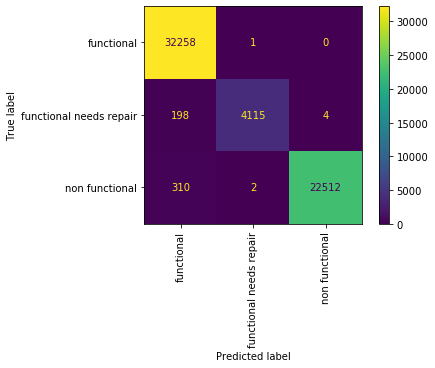

In [17]:
# I actually only have training data after cross-validation
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(search.best_estimator_, X_train, y_train, 
                      xticks_rotation=90, values_format='.0f');

In [18]:
# Split data so I can get a validation set
from sklearn.model_selection import train_test_split
train_subset, val_subset = train_test_split(train, train_size=0.80, 
                              test_size=0.20, stratify=train['status_group'],
                              random_state=42)

target = 'status_group'
features = train.columns.drop([target])
X_train = train_subset[features]
y_train = train_subset[target]
X_val = val_subset[features]
y_val = val_subset[target]

# Create a simple pipeline without cross-validation, to get a better example
pipe = make_pipeline(ce.OrdinalEncoder(),
                     SimpleImputer(strategy='most_frequent'),
                     RandomForestClassifier(n_estimators=450, max_depth=25, 
                                            max_features=.25, random_state=42))

# Fit everything on train
pipe.fit(X_train, y_train)

# Get training and validation scores
print('Train Accuracy', pipe.score(X_train, y_train))
print('Validation Accuracy', pipe.score(X_val, y_val))

Train Accuracy 0.9966329966329966
Validation Accuracy 0.8127946127946128


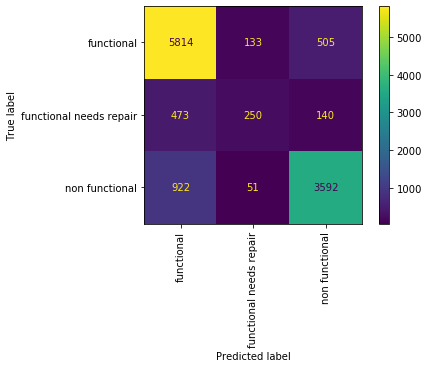

In [19]:
# This matrix represents a validation score
plot_confusion_matrix(pipe, X_val, y_val, xticks_rotation=90, 
                      values_format='.0f');

## Expanding on my own work

In [0]:
# Start over so I can keep things organized

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')

# Feature engineering: cluster the latitude and longitude coordinates
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=20)
train['cluster'] = kmeans.fit_predict(train[['longitude', 'latitude']])
test['cluster'] = kmeans.predict(test[['longitude', 'latitude']])

# feature engineering: number of other pumps within a certain distance
# setting a .1 default for distance because these are long distances
#   Length of 1° of latitude = always 111.32 km
#   Length of 1° of longitude = 40075 km * cos( latitude ) / 360
def count_neighbors(data, row, max_distance=.1):
  """ 
  returns the number of neighbors by checking distance using 
  lat/lon coordinates, closer than max_distance

  since I'm not calculating euclidian distance (which took far longer), 
  this is essentially a square with radius max_distance
  """
  squared_dist = max_distance**2
  this_point = [data.iloc[row]['longitude'], data.iloc[row]['latitude']]
  count = 0
  
  return len(data[((data['longitude']-this_point[0])**2 < squared_dist) &
                  ((data['latitude']-this_point[1])**2 < squared_dist)])

# Data wrangling I already had from the lectures and other assignments
def clean_engineer(X):
    """Clean and engineer the different sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
            
    # drop some duplicate, constant, or unique columns
    cols_to_drop = ['quantity_group', 'payment', 'recorded_by']
    X = X.drop(columns=cols_to_drop)

    # 'amount_tsh' is 70% 0's, replace those with the mean of all 
    # non-zero values, minus the top 1% (found during exploration)
    X['amount_tsh'] = X['amount_tsh'].replace(0, 641.5)

    # Region code and district code should be categorical (cardinalies 27 & 20)
    X['region_code'] = X['region_code'].astype(str)
    X['district_code'] = X['district_code'].astype(str)

    # We want to treat the new cluster column as categorical
    X['cluster'] = X['cluster'].astype(str)

    # New feature: number of years from construction_year to date_recorded
    # missing construction years will result in nans that are imputed later
    X['date_recorded'] = pd.to_datetime(X['date_recorded'])
    X['report_age'] = X['date_recorded'].dt.year - X['construction_year']

    # Date itself is unnecessary here
    X = X.drop(columns='date_recorded')

    # Use my neighbors function to engineer a new column
    X['neighbor_count'] = X['longitude'] * 0
    for i in range(len(X)):
      if ~np.isnan(X.at[i, 'neighbor_count']):
        X.at[i, 'neighbor_count'] = count_neighbors(X, i, max_distance=.1)
    
    # return the wrangled dataframe
    return X


train = clean_engineer(train)
test = clean_engineer(test)

In [224]:
# Try using regression to predict some of the numerical nan data, 
# instead of simply imputing it
from sklearn.linear_model import RidgeCV
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import mean_absolute_error

def regress_nans(target):
  high_cardinality = list(train.describe(exclude='number').T.
                          sort_values('unique').index[-7:])
  features = train.columns.drop([target, 'status_group', 'id'] + high_cardinality)

  # Known training data
  train_known = train[~train[target].isnull()]
  train_subset, val_subset = train_test_split(train_known, train_size=0.80, 
                            test_size=0.20, stratify=train_known['status_group'], 
                            random_state=42)

  X_train = train_subset[features]
  y_train = train_subset[target]
  X_val = val_subset[features]
  y_val = val_subset[target]

  # Make and fit a simple pipeline
  pipeline = make_pipeline(
      ce.OneHotEncoder(),
      SimpleImputer(strategy='mean'),
      SelectKBest(k=10),
      RidgeCV(alphas=[.01, .1, 1, 10])
  )
  pipeline.fit(X_train, y_train)

  # Use the model to fill in missing values in both train and test
  train_missing = train[train[target].isnull()].copy()
  train_missing[target] = pipeline.predict(train_missing[features])
  for i in range(len(train_missing.index)):
    j = train_missing.index[i]
    train.at[j,target] = train_missing.iloc[i][target]

  test_missing = test[test[target].isnull()].copy()
  test_missing[target] = pipeline.predict(test_missing[features])
  for i in range(len(test_missing.index)):
    j = test_missing.index[i]
    test.at[j,target] = test_missing.iloc[i][target]

# Call function on the missing data
regress_nans('latitude')
regress_nans('longitude')
regress_nans('neighbor_count')

C:\Users\thedo\Anaconda3\envs\unit2\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\thedo\Anaconda3\envs\unit2\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


In [218]:
# Now predict the actual target, 'status_group'

# Set up X and y variables
target = 'status_group'
features = train.columns.drop([target])
X_train = train[features]
y_train = train[target]

# Create the pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='most_frequent'),
    RandomForestClassifier()
)

# Set up parameters (using best ones found previously with RandomizedSearchCV)
param_distributions = {
    'simpleimputer__strategy': ['mean', 'median', 'most_frequent'],
    'randomforestclassifier__n_estimators': range(50, 501, 50),
    'randomforestclassifier__max_depth': [25, 50, 100, None],
    'randomforestclassifier__max_features': [.10,.25,.5,'auto']
}

# Set up randomized search to cross-validate
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=50, 
    cv=5, 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-3
)

# Run search on training data
search.fit(X_train, y_train);

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done   5 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-3)]: Done  12 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-3)]: Done  21 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-3)]: Done  30 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-3)]: Done  41 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-3)]: Done  52 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-3)]: Done  65 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-3)]: Done  78 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-3)]: Done  93 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-3)]: Done 108 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-3)]: Done 125 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-3)]: Done 142 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-3)]: Done 161 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-3)]: Done 180 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-3)]: Done 201 tasks      | elapsed: 2

In [219]:
# View the best model found
print('Best hyperparameters:', search.best_params_)
print('Cross-validation score:', search.best_score_)

Best hyperparameters: {'simpleimputer__strategy': 'most_frequent', 'randomforestclassifier__n_estimators': 450, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__max_depth': 25}
Cross-validation score: 0.8115824915824916


In [0]:
# Predict on test
y_test = search.best_estimator_.predict(test[features])

# Export .csv
submission = test[['id']].copy()
submission[target] = y_test
submission.to_csv('jduke_water_pump_submission6.csv', index=False)

### Ensemble submission

In [0]:
files = ['jduke_water_pump_submission.csv', 
         'jduke_water_pump_submission2.csv', 
         'jduke_water_pump_submission3.csv', 
         'jduke_water_pump_submission4.csv', 
         'jduke_water_pump_submission5.csv',
         'jduke_water_pump_submission6.csv',
         'jduke_water_pump_cv_submission.csv']
submissions = (pd.read_csv(file)[['status_group']] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = majority_vote
submission.to_csv('jduke_ensemble_submission.csv', index=False)